In [1]:
import os
import cv2
import collections
import time 
import tqdm
from tqdm import tqdm_notebook
import cv2
import math
import random
import gc
from PIL import Image
from functools import partial
train_on_gpu = True
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as imag
import seaborn as sns
from glob import glob
from pathlib import Path
%matplotlib inline
import albumentations as albu



from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset


from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.dl.runner import SupervisedRunner
from catalyst.contrib.models.segmentation import Unet
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback

import segmentation_models_pytorch as smp

from fastai.callbacks import (LossMetrics, hook_outputs, CSVLogger, SaveModelCallback,
                              ReduceLROnPlateauCallback, EarlyStoppingCallback)
from fastai.torch_core import children, num_children, children_and_parameters 
from fastai.basic_train import Learner
from fastai.basic_data import DataBunch, DatasetType
from fastai.train import to_fp16, to_fp32

In [2]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [3]:
data_dir = '/data2/aditya/Damage_Model/new_damage_data/'
image_ids = list(Path(data_dir+"images").glob('**/*.png'))
mask_ids = list(Path(data_dir+"masks").glob('**/*.png'))
print(len(image_ids))
image_train_ids, image_valid_ids, mask_train_ids, mask_valid_ids = train_test_split(image_ids, mask_ids, test_size=0.2, random_state=42)

939


In [4]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ["void", "damage"]
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
#         self.ids = os.listdir(images_dir)
#         self.ids = list(Path(images_dir).glob('**/*.png'))
        self.images_fps = images_dir
        self.masks_fps = masks_dir
#         self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
#         self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(str(self.images_fps[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(self.masks_fps[i]), 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_fps)

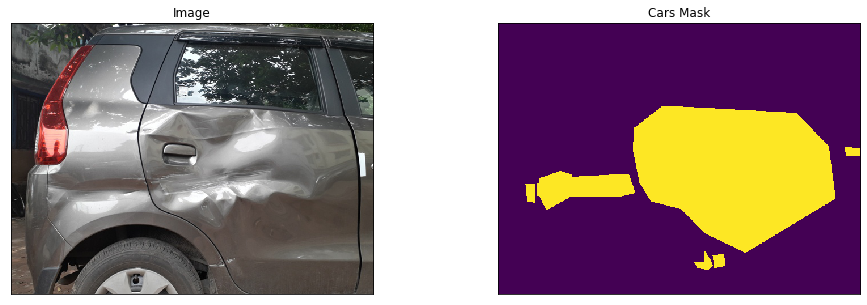

In [5]:
dataset = Dataset(image_train_ids, mask_train_ids, classes=["damage"])

image, mask = dataset[50] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [6]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

#         albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
#         albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Resize(448, 448),
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

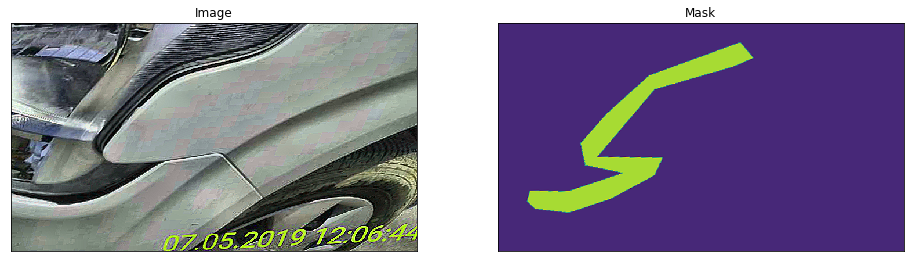

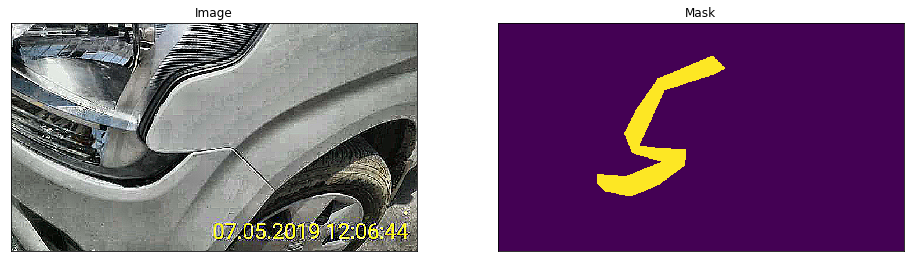

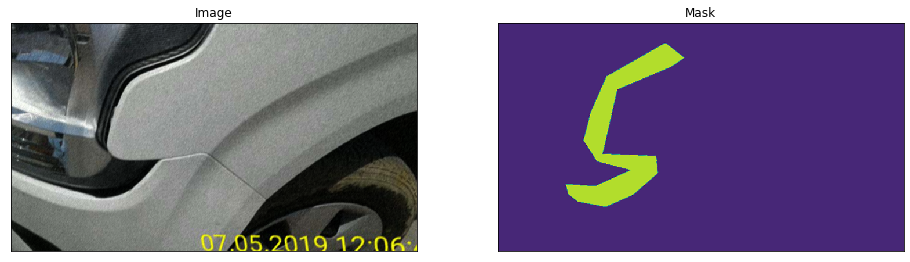

In [7]:
augmented_dataset = Dataset(
    image_train_ids, 
    mask_train_ids, 
    augmentation=get_training_augmentation(), 
    classes=['damage'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))



In [8]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
max_workers = os.cpu_count()

In [9]:
def dice_torch(inp, targs, eps=1e-7):
    inp = inp.sigmoid()
    intersect = (targs * inp).sum()
    union = (inp + targs).sum()
    dice = 2 * intersect / (union+eps)
    return dice

def split_model(m, mname):
    flatten_model = lambda m: sum(map(flatten_model, children_and_parameters(m)),[]) if num_children(m) else [m]
    layer_gp_map = {
        'resnet18': [25, 23],
        'resnet34': [40, 48],
        'resnet50': [56, 66],
        'resnext50_32x4d': [56, 67],
        'se_resnext50_32x4d': [91, 111],
        'efficientnet-b0': [121, 122],
        'efficientnet-b1': [163, 182],
        'efficientnet-b2': [163, 182],
        'efficientnet-b3': [193, 197],
        'efficientnet-b4': [238, 242],
        'efficientnet-b5': [280, 302],
        'efficientnet-b6': [325, 347],
        'efficientnet-b7': [397, 422]
    }
    
    m = flatten_model(m)
    a, b = layer_gp_map[mname]
    return [nn.Sequential(*m[:a+1]), nn.Sequential(*m[a+1:a+b+2]), nn.Sequential(*m[a+b+2:])]

In [10]:
def dice_loss(y_pred, y_true):
    smooth = 1.
    y_pred = y_pred.sigmoid()
    intersect = (y_true * y_pred).sum()
    union = (y_pred + y_true).sum()
    score = (2*intersect + smooth) / (union + smooth)
    return 1. - score

class BCEDiceLoss(nn.Module):
    def __init__(self): super().__init__()
        
    def forward(self, y_pred, y_true):
        bce = F.binary_cross_entropy_with_logits(y_pred, y_true)
        dice = dice_loss(y_pred, y_true)
        return bce + dice

In [11]:
class RAdam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr: raise ValueError(f'Invalid learning rate: {lr}')
        if not 0.0 <= eps: raise ValueError(f'Invalid epsilon value: {eps}')
        if not 0.0 <= betas[0] < 1.0: raise ValueError(f'Invalid beta parameter at index 0: {betas[0]}')
        if not 0.0 <= betas[1] < 1.0: raise ValueError(f'Invalid beta parameter at index 1: {betas[1]}')
        
        self.degenerated_to_sgd = degenerated_to_sgd
        
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, buffer=[[None, None, None] for _ in range(10)])
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state): super().__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None: loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue
                grad = p.grad.data.float()
                if grad.is_sparse: raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss

In [12]:
MODEL_NAME = 'efficientnet-b6'
SEED = 104

# PATH_IMGS = Path('train_imgs/train_imgs')
# PATH_MASKS = Path('train_masks/train_masks')
# PATH_TEST = Path('test_imgs/test_imgs')

In [13]:
def seed_everything(seed=7):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
#     np.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

In [14]:
preprocessing_fn = smp.encoders.get_preprocessing_fn("resnext50_32x4d", "imagenet")
CLASSES = ["damage"]

In [15]:
train_dataset = Dataset(
    image_train_ids, 
    mask_train_ids, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    image_valid_ids, 
    mask_valid_ids, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=max_workers)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=max_workers)

/home/humonics/.virtualenvs/yolo/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2247: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().



In [16]:
data = DataBunch(train_loader, valid_loader)

In [17]:
iou = smp.utils.metrics.IoU(eps=1.)
fscore = smp.utils.metrics.Fscore(eps=1.)
# metrics = [
#     smp.utils.metrics.IoUMetric(eps=1.),
#     smp.utils.metrics.FscoreMetric(eps=1.),
# ]

In [18]:
# learn = Learner(
#     data,
#     smp.Unet(encoder_name=MODEL_NAME, encoder_weights="imagenet", classes=len(CLASSES), activation=None,),
#     loss_func= BCEDiceLoss(),
#     opt_func=RAdam,
#     metrics=[dice_torch, iou, fscore],
#     callback_fns=[partial(CSVLogger, append=True, filename="b6-aug-actn-bcedice-r-3")])

# learn = to_fp16(learn)
# learn.layer_groups = split_model(learn.model, MODEL_NAME)
# # learn.unfreeze()

In [23]:
learn = Learner(
    data,
    smp.FPN(encoder_name=MODEL_NAME, encoder_depth=8, classes=len(CLASSES), activation=None),
    loss_func= BCEDiceLoss(),
    opt_func=RAdam,
    metrics=[dice_torch, iou, fscore],
    callback_fns=[partial(CSVLogger, append=True, filename="fpn-b6-aug-actn-bcedice-r-5")])

learn = to_fp16(learn)
learn.layer_groups = split_model(learn.model, MODEL_NAME)
# learn.unfreeze()

In [24]:
# learn = Learner(
#     data,
#     smp.PSPNet(encoder_name=MODEL_NAME, encoder_weights="imagenet", encoder_depth=5, classes=len(CLASSES), activation=None,),
#     loss_func= BCEDiceLoss(),
#     opt_func=RAdam,
#     metrics=[dice_torch, iou, fscore],
#     callback_fns=[partial(CSVLogger, append=True, filename="psp-b6-aug-actn-bcedice-r-3")])

# learn = to_fp16(learn)
# learn.layer_groups = split_model(learn.model, MODEL_NAME)
# # learn.unfreeze()

In [51]:
learn.model = torch.nn.DataParallel(learn.model)

In [25]:
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi

Thu Dec  5 11:59:02 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 74%   68C    P2    67W / 280W |   1369MiB / 11178MiB |     28%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 81%   79C    P2   163W / 280W |  10977MiB / 11178MiB |     97%      Default |
+-------------------------------+----------------------+----------------------+
        

In [26]:
learn.freeze()

In [ ]:
cbs = [SaveModelCallback(learn, every='improvement', monitor='iou_score', name=f'psp-b6-aug-actn-bcedice-r-3')]

learn.fit_one_cycle(25, 1e-3, callbacks=cbs)

epoch,train_loss,valid_loss,dice_torch,iou_score,fscore,time
0,1.282281,1.189883,0.092903,0.003174,0.006314,01:00
1,1.125996,0.942645,0.292316,0.163304,0.276852,01:01
2,1.009929,0.855591,0.396639,0.290338,0.446352,01:02
3,0.907270,0.837805,0.394847,0.234704,0.374955,01:02
4,0.832331,0.798659,0.416699,0.282751,0.430852,01:02
5,0.793481,0.932779,0.326671,0.150708,0.252345,01:01
6,0.792320,0.736580,0.490103,0.355575,0.517014,01:02
7,0.722893,0.683503,0.503723,0.347421,0.504380,01:02
8,0.664240,0.647439,0.543554,0.385238,0.549683,01:02
9,0.636957,0.670994,0.532347,0.378049,0.540334,01:01


Better model found at epoch 0 with iou_score value: 0.0031735808588564396.
Better model found at epoch 1 with iou_score value: 0.16330432891845703.
Better model found at epoch 2 with iou_score value: 0.29033759236335754.
Better model found at epoch 6 with iou_score value: 0.35557496547698975.
Better model found at epoch 8 with iou_score value: 0.38523828983306885.
Better model found at epoch 10 with iou_score value: 0.4316132664680481.
Better model found at epoch 15 with iou_score value: 0.44405144453048706.
Better model found at epoch 18 with iou_score value: 0.4490914046764374.
Better model found at epoch 23 with iou_score value: 0.45763304829597473.


In [ ]:
learn.load("fpn-b6-aug-actn-bcedice-r-5");

In [48]:
learn.unfreeze()

In [49]:
cbs = [SaveModelCallback(learn, every='improvement', monitor='iou_score', name=f'fpn-b6-aug-actn-bcedice-r-7-unf')]

learn.fit_one_cycle(25, slice(1e-9, 1e-7), callbacks=cbs)

epoch,train_loss,valid_loss,dice_torch,iou_score,fscore,time
0,0.314559,0.565469,0.648680,0.498960,0.661650,01:15
1,0.299628,0.577838,0.636218,0.484479,0.648965,01:17
2,0.295203,0.578716,0.635100,0.484137,0.648666,01:16
3,0.290320,0.570679,0.643181,0.494119,0.656293,01:17
4,0.290138,0.583928,0.630501,0.479485,0.643069,01:16
5,0.298017,0.574540,0.638784,0.490085,0.652604,01:17
6,0.294768,0.583671,0.630119,0.483203,0.642064,01:17
7,0.299612,0.573953,0.639760,0.495559,0.652118,01:17
8,0.291882,0.567328,0.647197,0.497869,0.660196,01:17
9,0.289706,0.567544,0.647143,0.497345,0.661020,01:17


Better model found at epoch 0 with iou_score value: 0.49895957112312317.
Better model found at epoch 11 with iou_score value: 0.5003321766853333.
Better model found at epoch 20 with iou_score value: 0.5026791095733643.


In [ ]:
# learn.show_results()
# highest tiil now iou= 0.47087183594703674(b6-waug-actn-bcedice-r-4-unf) #

In [40]:
learn = Learner(
    data,
    smp.FPN(encoder_name=MODEL_NAME, classes=len(CLASSES), activation="sigmoid"),
    loss_func= BCEDiceLoss(),
    opt_func=RAdam,
    metrics=[dice_torch, iou, fscore],
    callback_fns=[partial(CSVLogger, append=True, filename="fpn-b6-aug-actn-bcedice-r-5")])

learn = to_fp16(learn)
learn.layer_groups = split_model(learn.model, MODEL_NAME)
# learn.unfreeze()
learn.load("fpn-b6-aug-actn-bcedice-r-7-unf");

In [41]:
learn1 = Learner(
    data,
    smp.Unet(encoder_name=MODEL_NAME, encoder_weights="imagenet", classes=len(CLASSES), activation="sigmoid"),
    loss_func= BCEDiceLoss(),
    opt_func=RAdam,
    metrics=[dice_torch, iou, fscore],
    callback_fns=[partial(CSVLogger, append=True, filename="b6-aug-actn-bcedice-r-3")])

learn1 = to_fp16(learn1)
learn1.layer_groups = split_model(learn.model, MODEL_NAME)
learn1.load("b6-waug-actn-logit-r-3-unf");

In [45]:
# learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [42]:
# smp.utils.losses.BCEWithLogitsLoss
learn = to_fp32(learn)
learn1 = to_fp32(learn1)

In [43]:
# valid_loader = to_fp16(valid_loader)

In [44]:
test_epoch = smp.utils.train.ValidEpoch(
    model=learn.model,
    loss=smp.utils.losses.BCEWithLogitsLoss(),
    metrics=[iou, fscore],
    device = 'cuda',
)

logs = test_epoch.run(valid_loader)

valid: 100%|██████████| 12/12 [00:06<00:00,  2.34it/s, bce_with_logits_loss - 0.6889, iou_score - 0.4853, fscore - 0.6489]


In [45]:
test_epoch1 = smp.utils.train.ValidEpoch(
    model=learn1.model,
    loss=smp.utils.losses.BCEWithLogitsLoss(),
    metrics=[iou, fscore],
    device = 'cuda',
)

logs1 = test_epoch1.run(valid_loader)

valid: 100%|██████████| 12/12 [00:06<00:00,  2.26it/s, bce_with_logits_loss - 0.6879, iou_score - 0.474, fscore - 0.64]   


In [46]:
# model = torch.load("./models/b6-waug-actn-logit-r-3-unf.pth")

In [47]:
test_dataset_vis = Dataset(
    image_valid_ids, mask_valid_ids, 
    classes=CLASSES,
)


In [48]:
# learn.load("b6-waug-actn-logit-r-3-unf")
# lear

In [49]:
# learn.model = learn.model.cuda(1)

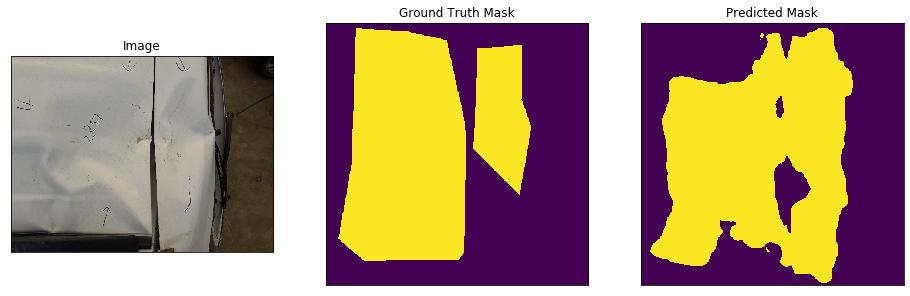

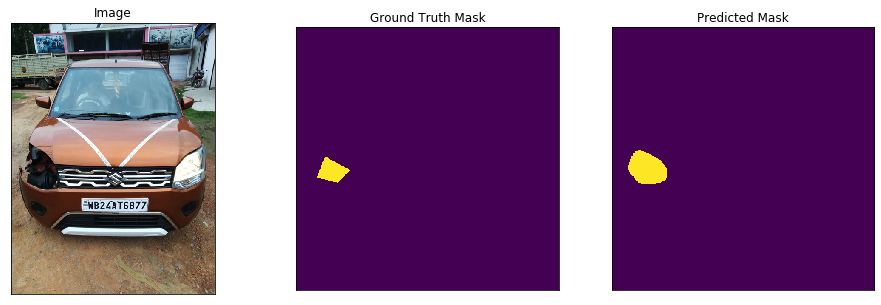

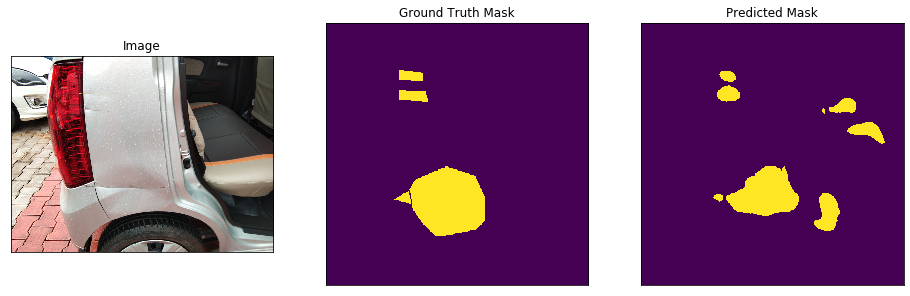

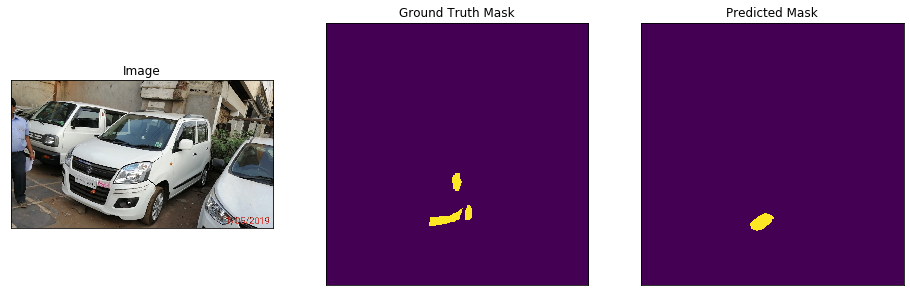

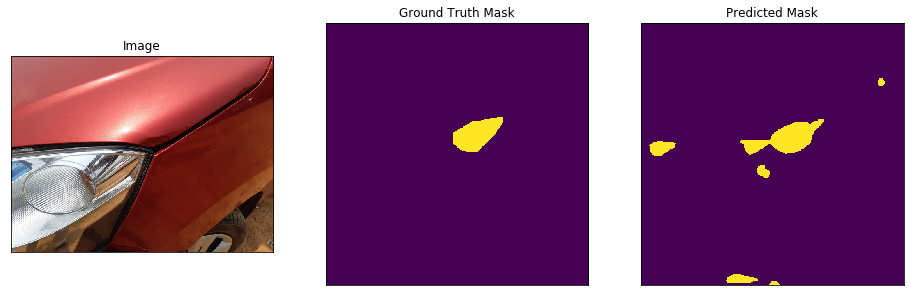

In [54]:
for i in range(5):
    n = np.random.choice(len(valid_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = valid_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to("cuda").unsqueeze(0)
    pr_mask1 = learn.model.predict(x_tensor)
    pr_mask1 = (pr_mask1.squeeze().cpu().numpy().round())
    
    pr_mask2 = learn1.model.predict(x_tensor)
    pr_mask2 = (pr_mask2.squeeze().cpu().numpy().round())
    
    pr_mask = np.logical_or(pr_mask1, pr_mask2)
    
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [69]:
data.show_batch()

AttributeError: 'Dataset' object has no attribute 'x'

In [70]:
learn.predict??

In [18]:
smp.FPN??